# Rocket Bunny Dashboard Prototype

FILENAME: rb_visuals.ipynb

DATE CREATED: 10-APR-21

## PHASE 1: Environment Setup

In [1]:
!pip3 install pycoingecko

In [102]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
from pandas import DataFrame
import numpy as np
import getpass as gp

import pandas_ta as ta
import requests
from pycoingecko import CoinGeckoAPI
from statsmodels.tsa.arima_model import ARIMA

from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import getpass as gp

import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

Function declaration

In [3]:
def is_ma_pos(val):
    
    if val > 0:
        return True
    else:
        return False

In [4]:
def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [5]:
def rma(x, n, y0):
        a = (n-1) / n
        ak = a**np.arange(len(x)-1, -1, -1)
        return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

Class definition

## PHASE 2: Data ETL

Read in the raw data

In [6]:
cg = CoinGeckoAPI()
cg.get_coins_list()

[{'id': '01coin', 'symbol': 'zoc', 'name': '01coin'},
 {'id': '0-5x-long-algorand-token',
  'symbol': 'algohalf',
  'name': '0.5X Long Algorand Token'},
 {'id': '0-5x-long-altcoin-index-token',
  'symbol': 'althalf',
  'name': '0.5X Long Altcoin Index Token'},
 {'id': '0-5x-long-balancer-token',
  'symbol': 'balhalf',
  'name': '0.5X Long Balancer Token'},
 {'id': '0-5x-long-bitcoin-cash-token',
  'symbol': 'bchhalf',
  'name': '0.5X Long Bitcoin Cash Token'},
 {'id': '0-5x-long-bitcoin-sv-token',
  'symbol': 'bsvhalf',
  'name': '0.5X Long Bitcoin SV Token'},
 {'id': '0-5x-long-bitcoin-token',
  'symbol': 'half',
  'name': '0.5X Long Bitcoin Token'},
 {'id': '0-5x-long-cardano-token',
  'symbol': 'adahalf',
  'name': '0.5X Long Cardano Token'},
 {'id': '0-5x-long-chainlink-token',
  'symbol': 'linkhalf',
  'name': '0.5X Long Chainlink Token'},
 {'id': '0-5x-long-cosmos-token',
  'symbol': 'atomhalf',
  'name': '0.5X Long Cosmos Token'},
 {'id': '0-5x-long-defi-index-token',
  'symbol'

In [7]:
raw_data = pd.read_csv("data/bunny-usd-max.csv")
#data = data.query("type == 'conventional' and region == 'Albany'")
#raw_data["date"] = pd.to_datetime(raw_data["date"], format="%Y-%m-%d")

#data.sort_values("Date", inplace=True)

raw_data.head(5)

,snapped_at,price,market_cap,total_volume
0,2021-03-12 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07
1,2021-03-13 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07
2,2021-03-14 00:00:00 UTC,2.723985e-11,0.0,4.711907e+06
3,2021-03-15 00:00:00 UTC,2.276712e-11,0.0,1.814948e+06
4,2021-03-16 00:00:00 UTC,3.197680e-11,0.0,1.701247e+06


In [8]:
app = dash.Dash(__name__)

In [9]:

data = raw_data.rename({'snapped_at': 'dtg'}, axis=1)
data.dtypes

dtg              object
price           float64
market_cap      float64
total_volume    float64
dtype: object

In [10]:
col_list = list(data.columns)
col_list

['dtg', 'price', 'market_cap', 'total_volume']

In [11]:
close_np = data['price'].to_list()
close_np

[3.544890372449417e-11,
 3.544890372449417e-11,
 2.7239851621885825e-11,
 2.276711980520152e-11,
 3.1976800418536546e-11,
 2.8077474254547858e-11,
 2.1126616432418585e-11,
 2.0963108885770787e-11,
 1.7818568348394942e-11,
 1.714732901367917e-11,
 1.2481281902033133e-11,
 1.2533681483670114e-11,
 1.1875716146667161e-11,
 9.457534146178276e-12,
 7.305428315404949e-12,
 8.744554690166982e-12,
 7.207941603822242e-12,
 7.650775307094981e-12,
 9.388180178763074e-12,
 7.174640793551023e-12,
 8.115413911027787e-12,
 7.999102012443927e-12,
 8.651487749048858e-12,
 9.409349711694989e-12,
 1.0896905187671577e-11,
 1.5142164424853266e-11,
 1.6785648600218088e-11,
 1.0765405784247136e-11,
 1.4312424017942007e-11,
 1.4048118388124779e-11,
 1.1963189826467365e-11,
 1.2699972771176136e-11,
 1.1419131925727329e-11,
 1.018680681125154e-11,
 1.1735694210638596e-11,
 1.087416484991724e-11,
 1.6041310947745593e-11,
 1.6507045452453323e-11,
 1.7379380747873198e-11,
 2.5355351928978517e-11,
 2.29100168912033

In [12]:
data['date'] = pd.to_datetime(data['dtg']).dt.date
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['hour'] = pd.DatetimeIndex(data['date']).hour.astype(str)

In [13]:
data

,dtg,price,market_cap,total_volume,date,year,month,day,hour
0,2021-03-12 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07,2021-03-12,2021,3,12,0
1,2021-03-13 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07,2021-03-13,2021,3,13,0
2,2021-03-14 00:00:00 UTC,2.723985e-11,0.0,4.711907e+06,2021-03-14,2021,3,14,0
3,2021-03-15 00:00:00 UTC,2.276712e-11,0.0,1.814948e+06,2021-03-15,2021,3,15,0
4,2021-03-16 00:00:00 UTC,3.197680e-11,0.0,1.701247e+06,2021-03-16,2021,3,16,0
...,...,...,...,...,...,...,...,...,...
64,2021-05-15 00:00:00 UTC,1.324111e-10,0.0,5.179934e+05,2021-05-15,2021,5,15,0
65,2021-05-16 00:00:00 UTC,1.031283e-10,0.0,2.979225e+05,2021-05-16,2021,5,16,0
66,2021-05-17 00:00:00 UTC,9.762382e-11,0.0,5.086093e+05,2021-05-17,2021,5,17,0
67,2021-05-18 00:00:00 UTC,7.497404e-11,0.0,3.177894e+05,2021-05-18,2021,5,18,0


Calculate 'gain' and 'loss' columns

In [14]:
data['close_diff'] = data['price'].diff()
data['bool_close_diff'] = data['close_diff'].apply(is_ma_pos)

In [90]:
data['gain'] = data.close_diff.mask(data.close_diff < 0, 0.0)
data['initial_loss'] = -data.close_diff.mask(data.close_diff > 0, -0.0)
data['loss'] = data['initial_loss']*-1

n=14 # rsi window number
data['avg_gain'] = rma(data.gain[n+1:].to_numpy(), n, np.nansum(data.gain.to_numpy()[:n+1])/n)
data['avg_loss'] = rma(data.loss[n+1:].to_numpy(), n, np.nansum(data.loss.to_numpy()[:n+1])/n)


Calculate rolling mean

In [77]:
data['SMA7'] = data['price'].rolling(window=7).mean()
data['SMA30'] = data['price'].rolling(window=30).mean()

Calculate rolling standard deviation

In [78]:
data['STD7'] = data['price'].rolling(window=7).std()
data['STD30'] = data['price'].rolling(window=30).std()

#data['STD99'] = self.aggregate_df['Close'].rolling(window=99).std()

Calculate rolling variance

In [79]:
data['VAR7'] = data['price'].rolling(window=7).var()
data['VAR30'] = data['price'].rolling(window=30).var()

#data['VAR99'] = self.aggregate_df['Close'].rolling(window=99).var()

Calculate MACD

In [80]:
data['SMA-MACD'] = data['SMA7'] - data['SMA30']
data['SMA-MACD-ratio'] = data['SMA7'] / data['SMA30']
data['bool_diff_SMA7_SMA30'] = data['SMA-MACD'].apply(is_ma_pos)

Calculate EMA

In [81]:
window = 12

In [82]:
data["EMA12"] = ta.ema(data["price"], length=12)
data["EMA20"] = ta.ema(data["price"], length=20)
data

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14,vol_price_kpi
0,2021-03-12 00:00:00 UTC,0.000,0.000,12698721.435,2021-03-12,2021,3,12,0,nan,...,nan,nan,nan,False,nan,nan,nan,nan,nan,358226069110159936.000
1,2021-03-13 00:00:00 UTC,0.000,0.000,12698721.435,2021-03-13,2021,3,13,0,0.000,...,nan,nan,nan,False,nan,nan,nan,nan,nan,358226069110159936.000
2,2021-03-14 00:00:00 UTC,0.000,0.000,4711906.810,2021-03-14,2021,3,14,0,-0.000,...,nan,nan,nan,False,nan,nan,-0.000,nan,nan,172978431595027936.000
3,2021-03-15 00:00:00 UTC,0.000,0.000,1814948.363,2021-03-15,2021,3,15,0,-0.000,...,nan,nan,nan,False,nan,nan,0.000,nan,nan,79717960733250000.000
4,2021-03-16 00:00:00 UTC,0.000,0.000,1701246.533,2021-03-16,2021,3,16,0,0.000,...,nan,nan,nan,False,nan,nan,0.000,nan,nan,53202525280295696.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2021-05-15 00:00:00 UTC,0.000,0.000,517993.371,2021-05-15,2021,5,15,0,0.000,...,0.000,0.000,2.095,True,0.000,0.000,0.000,1.103,52.447,3912007700393770.000
65,2021-05-16 00:00:00 UTC,0.000,0.000,297922.512,2021-05-16,2021,5,16,0,-0.000,...,0.000,0.000,2.161,True,0.000,0.000,-0.000,0.807,44.666,2888854352467490.000
66,2021-05-17 00:00:00 UTC,0.000,0.000,508609.317,2021-05-17,2021,5,17,0,-0.000,...,0.000,0.000,2.211,True,0.000,0.000,0.000,0.947,48.647,5209889544087290.000
67,2021-05-18 00:00:00 UTC,0.000,0.000,317789.412,2021-05-18,2021,5,18,0,-0.000,...,0.000,0.000,2.152,True,0.000,0.000,-0.000,0.854,46.073,4238659238470590.000


In [83]:
data.tail(5)

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14,vol_price_kpi
64,2021-05-15 00:00:00 UTC,0.000,0.000,517993.371,2021-05-15,2021,5,15,0,0.000,...,0.000,0.000,2.095,True,0.000,0.000,0.000,1.103,52.447,3912007700393770.000
65,2021-05-16 00:00:00 UTC,0.000,0.000,297922.512,2021-05-16,2021,5,16,0,-0.000,...,0.000,0.000,2.161,True,0.000,0.000,-0.000,0.807,44.666,2888854352467490.000
66,2021-05-17 00:00:00 UTC,0.000,0.000,508609.317,2021-05-17,2021,5,17,0,-0.000,...,0.000,0.000,2.211,True,0.000,0.000,0.000,0.947,48.647,5209889544087290.000
67,2021-05-18 00:00:00 UTC,0.000,0.000,317789.412,2021-05-18,2021,5,18,0,-0.000,...,0.000,0.000,2.152,True,0.000,0.000,-0.000,0.854,46.073,4238659238470590.000
68,2021-05-19 00:00:00 UTC,0.000,0.000,312813.300,2021-05-19,2021,5,19,0,0.000,...,0.000,0.000,1.892,True,0.000,0.000,0.000,1.070,51.702,3579485222604780.500


In [84]:
col_list = list(data.columns)
col_list

['dtg',
 'price',
 'market_cap',
 'total_volume',
 'date',
 'year',
 'month',
 'day',
 'hour',
 'close_diff',
 'bool_close_diff',
 'gain',
 'loss',
 'avg_gain',
 'avg_loss',
 'SMA7',
 'SMA30',
 'STD7',
 'STD30',
 'VAR7',
 'VAR30',
 'SMA-MACD',
 'SMA-MACD-ratio',
 'bool_diff_SMA7_SMA30',
 'EMA12',
 'EMA20',
 'change',
 'rs',
 'rsi_14',
 'vol_price_kpi']

### ARIMA

In [85]:
price_series = data['price'].values
price_series

array([3.54489037e-11, 3.54489037e-11, 2.72398516e-11, 2.27671198e-11,
       3.19768004e-11, 2.80774743e-11, 2.11266164e-11, 2.09631089e-11,
       1.78185683e-11, 1.71473290e-11, 1.24812819e-11, 1.25336815e-11,
       1.18757161e-11, 9.45753415e-12, 7.30542832e-12, 8.74455469e-12,
       7.20794160e-12, 7.65077531e-12, 9.38818018e-12, 7.17464079e-12,
       8.11541391e-12, 7.99910201e-12, 8.65148775e-12, 9.40934971e-12,
       1.08969052e-11, 1.51421644e-11, 1.67856486e-11, 1.07654058e-11,
       1.43124240e-11, 1.40481184e-11, 1.19631898e-11, 1.26999728e-11,
       1.14191319e-11, 1.01868068e-11, 1.17356942e-11, 1.08741648e-11,
       1.60413109e-11, 1.65070455e-11, 1.73793807e-11, 2.53553519e-11,
       2.29100169e-11, 3.69026266e-11, 3.76310234e-11, 3.46735085e-11,
       3.04382453e-11, 3.12313425e-11, 3.78611177e-11, 4.01247851e-11,
       3.07217065e-11, 2.72962765e-11, 2.75481218e-11, 3.29904780e-11,
       2.45247454e-11, 3.36585591e-11, 3.17244372e-11, 3.38418146e-11,
      

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
Test RMSE: 0.000


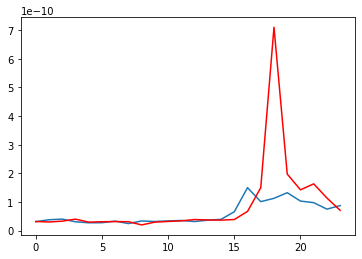

In [86]:
# split into train and test sets
X = price_series
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## PHASE 3: Data Visualization

Simple Moving Average (SMA) Visualization

In [87]:
sma_fig = go.Figure()
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['price'],
                    mode='lines',
                    name='Price Timeseries'))
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['SMA7'],
                    mode='lines',
                    name='Timeseries SMA7'))
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['SMA30'],
                    mode='lines', name='Timeseries SMA30'))

sma_fig.update_layout(
    title="Rocket Bunny Close Price and Simple Moving Average",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
sma_fig.show()

Closs differential

In [88]:
close_fig = go.Figure()
close_fig.add_trace(go.Scatter(x=data['date'], y=data['close_diff'],
                    mode='lines',
                    name='Price Timeseries'))

close_fig.update_layout(
    title="Rocket Bunny Close Differential Timeseries",
    xaxis_title="Date",
    yaxis_title="Daily Closing Price differential",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
close_fig.show()

Gain / Loss visualization 

In [91]:
gain_loss_fig = go.Figure()
gain_loss_fig.add_trace(go.Scatter(x=data['date'], y=data['gain'],
                    mode='lines',
                    name='Daily Gain Timeseries'))
gain_loss_fig.add_trace(go.Scatter(x=data['date'], y=data['loss'],
                    mode='lines',
                    name='Daily Loss Timeseries'))

gain_loss_fig.update_layout(
    title="Rocket Bunny Daily Change in Gain & Loss",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
gain_loss_fig.show()

#### Daily Volume Chart

In [231]:
vol_fig = px.bar(data, x='date', y='total_volume', title = "Rocket Bunny Daily Volume Chart")
vol_fig.show()

#### RSI Calculator

In [30]:
def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]



In [31]:
data['change'] = data['close_diff'].diff()
data['gain'] = data.change.mask(data.change < 0, 0.0)
data['loss'] = -data.change.mask(data.change > 0, -0.0)
data['avg_gain'] = rma(data.gain[n+1:].to_numpy(), n, np.nansum(data.gain.to_numpy()[:n+1])/n)
data['avg_loss'] = rma(data.loss[n+1:].to_numpy(), n, np.nansum(data.loss.to_numpy()[:n+1])/n)
data['rs'] = data.avg_gain / data.avg_loss
data['rsi_14'] = 100 - (100 / (1 + data.rs))
data.tail(5)

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR7,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14
64,2021-05-15 00:00:00 UTC,1.324111e-10,0.0,517993.371186,2021-05-15,2021,5,15,0,1.972443e-11,...,2.008434e-21,1.175970e-21,4.760636e-11,2.094500,True,7.977423e-11,6.372438e-11,8.180210e-12,1.102924,52.447163
65,2021-05-16 00:00:00 UTC,1.031283e-10,0.0,297922.511883,2021-05-16,2021,5,16,0,-2.928288e-11,...,1.429429e-21,1.252112e-21,5.405294e-11,2.160654,True,8.336716e-11,6.747713e-11,-4.900731e-11,0.807220,44.666380
66,2021-05-17 00:00:00 UTC,9.762382e-11,0.0,508609.317226,2021-05-17,2021,5,17,0,-5.504437e-12,...,7.224621e-22,1.302197e-21,5.966981e-11,2.210574,True,8.556049e-11,7.034825e-11,2.377844e-11,0.947314,48.647201
67,2021-05-18 00:00:00 UTC,7.497404e-11,0.0,317789.411638,2021-05-18,2021,5,18,0,-2.264978e-11,...,6.019745e-22,1.283953e-21,5.903656e-11,2.152171,True,8.393180e-11,7.078880e-11,-1.714534e-11,0.854371,46.073365
68,2021-05-19 00:00:00 UTC,8.739058e-11,0.0,312813.299892,2021-05-19,2021,5,19,0,1.241654e-11,...,3.334933e-22,1.283850e-21,4.776358e-11,1.891558,True,8.446392e-11,7.236992e-11,3.506632e-11,1.070468,51.701742


In [32]:
rsi_df = data[['date', 'rsi_14'] ]
rsi_df['lower'] = 30
rsi_df['upper'] = 70
rsi_df.tail(5)

<ipython-input-32-425aa5bb9acc>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-425aa5bb9acc>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,rsi_14,lower,upper
64,2021-05-15,52.447163,30,70
65,2021-05-16,44.666380,30,70
66,2021-05-17,48.647201,30,70
67,2021-05-18,46.073365,30,70
68,2021-05-19,51.701742,30,70


In [92]:
rsi_fig = go.Figure()
rsi_fig.add_trace(go.Scatter(x=rsi_df['date'], y=data['rsi_14'],
                    mode='lines',
                    name='RSI Value'))
rsi_fig.add_trace(go.Scatter(x=rsi_df['date'], y=rsi_df['lower'],
                    mode='lines',
                    name='70% Top Threshold'))
rsi_fig.add_trace(go.Scatter(x=rsi_df['date'], y=rsi_df['upper'],
                    mode='lines',
                    name='30% Bottom Threshold'))

rsi_fig.update_layout(
    title="Rocket Bunny RSI Chart",
    xaxis_title="Date",
    yaxis_title="RSI Value",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
rsi_fig.show()

#### Volume / Price KPI

In [34]:
data.tail(5)

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR7,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14
64,2021-05-15 00:00:00 UTC,1.324111e-10,0.0,517993.371186,2021-05-15,2021,5,15,0,1.972443e-11,...,2.008434e-21,1.175970e-21,4.760636e-11,2.094500,True,7.977423e-11,6.372438e-11,8.180210e-12,1.102924,52.447163
65,2021-05-16 00:00:00 UTC,1.031283e-10,0.0,297922.511883,2021-05-16,2021,5,16,0,-2.928288e-11,...,1.429429e-21,1.252112e-21,5.405294e-11,2.160654,True,8.336716e-11,6.747713e-11,-4.900731e-11,0.807220,44.666380
66,2021-05-17 00:00:00 UTC,9.762382e-11,0.0,508609.317226,2021-05-17,2021,5,17,0,-5.504437e-12,...,7.224621e-22,1.302197e-21,5.966981e-11,2.210574,True,8.556049e-11,7.034825e-11,2.377844e-11,0.947314,48.647201
67,2021-05-18 00:00:00 UTC,7.497404e-11,0.0,317789.411638,2021-05-18,2021,5,18,0,-2.264978e-11,...,6.019745e-22,1.283953e-21,5.903656e-11,2.152171,True,8.393180e-11,7.078880e-11,-1.714534e-11,0.854371,46.073365
68,2021-05-19 00:00:00 UTC,8.739058e-11,0.0,312813.299892,2021-05-19,2021,5,19,0,1.241654e-11,...,3.334933e-22,1.283850e-21,4.776358e-11,1.891558,True,8.446392e-11,7.236992e-11,3.506632e-11,1.070468,51.701742


In [35]:
data['vol_price_kpi'] = data['total_volume'] / data['price']
data.tail(5)

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14,vol_price_kpi
64,2021-05-15 00:00:00 UTC,1.324111e-10,0.0,517993.371186,2021-05-15,2021,5,15,0,1.972443e-11,...,1.175970e-21,4.760636e-11,2.094500,True,7.977423e-11,6.372438e-11,8.180210e-12,1.102924,52.447163,3.912008e+15
65,2021-05-16 00:00:00 UTC,1.031283e-10,0.0,297922.511883,2021-05-16,2021,5,16,0,-2.928288e-11,...,1.252112e-21,5.405294e-11,2.160654,True,8.336716e-11,6.747713e-11,-4.900731e-11,0.807220,44.666380,2.888854e+15
66,2021-05-17 00:00:00 UTC,9.762382e-11,0.0,508609.317226,2021-05-17,2021,5,17,0,-5.504437e-12,...,1.302197e-21,5.966981e-11,2.210574,True,8.556049e-11,7.034825e-11,2.377844e-11,0.947314,48.647201,5.209890e+15
67,2021-05-18 00:00:00 UTC,7.497404e-11,0.0,317789.411638,2021-05-18,2021,5,18,0,-2.264978e-11,...,1.283953e-21,5.903656e-11,2.152171,True,8.393180e-11,7.078880e-11,-1.714534e-11,0.854371,46.073365,4.238659e+15
68,2021-05-19 00:00:00 UTC,8.739058e-11,0.0,312813.299892,2021-05-19,2021,5,19,0,1.241654e-11,...,1.283850e-21,4.776358e-11,1.891558,True,8.446392e-11,7.236992e-11,3.506632e-11,1.070468,51.701742,3.579485e+15


In [233]:
vol_price_kpi_fig = px.line(data, x='date', y='vol_price_kpi')
vol_price_kpi_fig.show()

#### Exponential Moving Average Graph

In [37]:
ema_fig = go.Figure()
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['price'],
                    mode='lines',
                    name='Price Timeseries'))
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['EMA12'],
                    mode='lines',
                    name='Timeseries EMA 12'))
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['EMA20'],
                    mode='lines', name='Timeseries EMA 20'))

ema_fig.update_layout(
    title="Rocket Bunny Close Price and Exponential Moving Average",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
ema_fig.show()

#### Polynomial Regression

In [46]:
poly_df = data[['price', 'total_volume', 'close_diff']]

In [47]:
X = data.iloc[:, 1:2].values
y = data.iloc[:, 3].values


In [48]:
lin = LinearRegression()
  
lin.fit(X, y)

LinearRegression()

In [49]:


poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(X)
  
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)

LinearRegression()

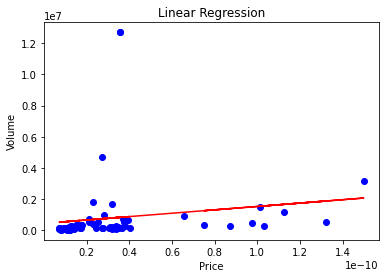

In [50]:
plt.scatter(X, y, color = 'blue')
  
plt.plot(X, lin.predict(X), color = 'red')
plt.title('Linear Regression')
plt.xlabel('Price')
plt.ylabel('Volume')
  
plt.show()

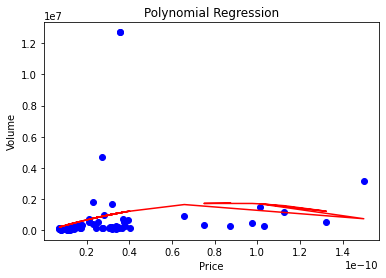

In [51]:
plt.scatter(X, y, color = 'blue')
  
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red')
plt.title('Polynomial Regression')
plt.xlabel('Price')
plt.ylabel('Volume')
  
plt.show()

## ARIMA Forecasting

In [52]:
data.head(5)

,dtg,price,market_cap,total_volume,date,year,month,day,hour,close_diff,...,VAR30,SMA-MACD,SMA-MACD-ratio,bool_diff_SMA7_SMA30,EMA12,EMA20,change,rs,rsi_14,vol_price_kpi
0,2021-03-12 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07,2021-03-12,2021,3,12,0,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,3.582261e+17
1,2021-03-13 00:00:00 UTC,3.544890e-11,0.0,1.269872e+07,2021-03-13,2021,3,13,0,0.000000e+00,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,3.582261e+17
2,2021-03-14 00:00:00 UTC,2.723985e-11,0.0,4.711907e+06,2021-03-14,2021,3,14,0,-8.209052e-12,...,NaN,NaN,NaN,False,NaN,NaN,-8.209052e-12,NaN,NaN,1.729784e+17
3,2021-03-15 00:00:00 UTC,2.276712e-11,0.0,1.814948e+06,2021-03-15,2021,3,15,0,-4.472732e-12,...,NaN,NaN,NaN,False,NaN,NaN,3.736320e-12,NaN,NaN,7.971796e+16
4,2021-03-16 00:00:00 UTC,3.197680e-11,0.0,1.701247e+06,2021-03-16,2021,3,16,0,9.209681e-12,...,NaN,NaN,NaN,False,NaN,NaN,1.368241e-11,NaN,NaN,5.320253e+16


In [53]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [54]:
series = data[['date', 'price']]
series.to_csv('data/rb_series.csv', index=False)
series

,date,price
0,2021-03-12,0.000
1,2021-03-13,0.000
2,2021-03-14,0.000
3,2021-03-15,0.000
4,2021-03-16,0.000
...,...,...
64,2021-05-15,0.000
65,2021-05-16,0.000
66,2021-05-17,0.000
67,2021-05-18,0.000


In [55]:
from pandas import read_csv
# load dataset
def parser(x):
	return date.strptime('190'+x, '%Y-%m')

In [56]:

series = read_csv('data/rb_series.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.index = series.index.to_period('M')


In [57]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


In [58]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [59]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.000


In [60]:
test

array([3.12313425e-11, 3.78611177e-11, 4.01247851e-11, 3.07217065e-11,
       2.72962765e-11, 2.75481218e-11, 3.29904780e-11, 2.45247454e-11,
       3.36585591e-11, 3.17244372e-11, 3.38418146e-11, 3.53149863e-11,
       3.16118411e-11, 3.64762299e-11, 3.92697953e-11, 6.57645348e-11,
       1.49965468e-10, 1.01142482e-10, 1.12686702e-10, 1.32411133e-10,
       1.03128256e-10, 9.76238196e-11, 7.49740410e-11, 8.73905828e-11])

In [61]:
predictions

[3.1763999993487437e-11,
 3.0078542376880205e-11,
 3.297395190243042e-11,
 3.99838511983352e-11,
 2.952763021094936e-11,
 3.098320603922856e-11,
 3.1462271032282565e-11,
 3.109707919963316e-11,
 1.981120570724217e-11,
 2.958862503349826e-11,
 3.184874868470999e-11,
 3.403005151142237e-11,
 3.857732474326128e-11,
 3.711534351255967e-11,
 3.649723219422852e-11,
 3.8621903037875707e-11,
 6.703951493047094e-11,
 1.4996546796771826e-10,
 7.104552161599189e-10,
 1.9749153464556523e-10,
 1.4243138472328116e-10,
 1.6325296340867806e-10,
 1.1379514604260682e-10,
 7.076931201737465e-11]

Rocket Bunny Timeseries (ARIMA) Forecasting

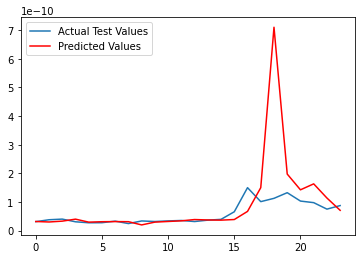

In [62]:
# plot forecasts against actual outcomes
pyplot.plot(test, label="Actual Test Values")
pyplot.plot(predictions, color='red', label="Predicted Values")
pyplot.legend(loc="upper left")

pyplot.show()

### Burn Rate Analytics

In [103]:
API_KEY = gp.getpass(prompt='Please enter your Etherscan API key: ')

Please enter your Etherscan API key: ········


In [185]:
rb_contract = '0x3Ea50B7Ef6a7eaf7E966E2cb72b519C16557497c'

Normal transactions

In [183]:
url = 'https://api.etherscan.io/api?module=account&action=txlist&address=0x3Ea50B7Ef6a7eaf7E966E2cb72b519C16557497c&startblock=0&endblock=99999999&sort=asc&apikey=' + API_KEY
url

'https://api.etherscan.io/api?module=account&action=txlist&address=0x3Ea50B7Ef6a7eaf7E966E2cb72b519C16557497c&startblock=0&endblock=99999999&sort=asc&apikey=TJTSNQKWSDWDSUMMZQ9GTVGHRTGY184U3K'

Internal transactions

In [184]:
internal_url = 'https://api.etherscan.io/api?module=account&action=txlistinternal&address=0x3Ea50B7Ef6a7eaf7E966E2cb72b519C16557497c&startblock=0&endblock=2702578&sort=asc&apikey=' + API_KEY

In [213]:
res = requests.get(url)
res

<Response [200]>

In [214]:
j = res.json()

etherscan_df = pd.DataFrame(j['result'])
etherscan_df.tail(5)

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,500000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,12033583,46552,794
6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,605000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,11490553,46552,752
6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,612000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,12391800,46552,723
6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,258000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,5262057,46552,222
6719,12466302,1621447222,0xde812d838a3ecbf2e66ef57cb7c1da19ec3ef137b8fc...,2,0xfdbdbef2b538c6b03727059b74a4d1c53941360ac32f...,214,0x649a5208f493c2a525ce510de49133c22d3829a6,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,233000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,11215536,46552,67


In [190]:
etherscan_df = etherscan_df.replace(',','', regex=True)
etherscan_df

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,11812643,1612745014,0xb8b23ea89a8583200f25fa71d96409d45e4746dfe83e...,1,0x0d919c04b58e70be9a6433e4e707f659e0704e74fed0...,42,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,,0,5133033,95000000000,0,1,0x600280547318159f21d6a2f72dc97fc1d2ddebcecfa6...,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,10420203,5133033,653703
1,11812884,1612748360,0x918504c32da1ee19e28fdb36ab5ea61831df81f5e906...,2,0x8d3d1c244135dfe1c6e9f4a49de09c8e56382d86f68d...,42,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,205741,101000001459,0,1,0xa9059cbb00000000000000000000000018159f21d6a2...,,3764834,205741,653462
2,11812903,1612748608,0x4cd298e54cdc10f6e939bfb16d0d351cb1e7d3d78665...,3,0x8578baddc4f807fec1d5e97a6f5fba2d8a963af28e10...,49,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,48897,101000001459,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,4356400,44452,653443
3,11812925,1612748834,0x1f750d4b483dabd89e4f62513c5b2d4bda7f56bbc214...,164,0xa00e72deb1b0de2e3ebdb4b4cbd2b57afd1147753244...,2,0xa07fb4ad8c0d211d13194960623b88bd76df7fe4,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55565,350000000000,0,1,0x095ea7b3000000000000000000000000a393a5e7a897...,,420123,44452,653421
4,11812928,1612748849,0x11f783b2aabbf24104572ebfe137172fe85ff7bd0035...,120,0xd0f4a71c10f833347c22da43c22dd589e2843e7a7dd5...,8,0xdc81a3450817a58d00f45c86d0368290088db848,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,60000,230000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,658275,44452,653418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,500000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,12033583,46552,771
6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,605000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,11490553,46552,729
6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,612000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,12391800,46552,700
6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,258000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,,5262057,46552,199


In [215]:
etherscan_df['value']

0       0
1       0
2       0
3       0
4       0
       ..
6715    0
6716    0
6717    0
6718    0
6719    0
Name: value, Length: 6720, dtype: object

In [216]:
# print(j)
filename ="data/rb_trx_data.csv"
etherscan_df.to_csv(filename)

In [217]:
df = pd.read_csv('data/rb_trx_data.csv')
df.head(5)

,Unnamed: 0,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,0,11812643,1612745014,0xb8b23ea89a8583200f25fa71d96409d45e4746dfe83e...,1,0x0d919c04b58e70be9a6433e4e707f659e0704e74fed0...,42,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,NaN,0,5133033,95000000000,0,1,0x600280547318159f21d6a2f72dc97fc1d2ddebcecfa6...,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,10420203,5133033,653726
1,1,11812884,1612748360,0x918504c32da1ee19e28fdb36ab5ea61831df81f5e906...,2,0x8d3d1c244135dfe1c6e9f4a49de09c8e56382d86f68d...,42,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,205741,101000001459,0,1,0xa9059cbb00000000000000000000000018159f21d6a2...,NaN,3764834,205741,653485
2,2,11812903,1612748608,0x4cd298e54cdc10f6e939bfb16d0d351cb1e7d3d78665...,3,0x8578baddc4f807fec1d5e97a6f5fba2d8a963af28e10...,49,0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,48897,101000001459,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,4356400,44452,653466
3,3,11812925,1612748834,0x1f750d4b483dabd89e4f62513c5b2d4bda7f56bbc214...,164,0xa00e72deb1b0de2e3ebdb4b4cbd2b57afd1147753244...,2,0xa07fb4ad8c0d211d13194960623b88bd76df7fe4,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55565,350000000000,0,1,0x095ea7b3000000000000000000000000a393a5e7a897...,NaN,420123,44452,653444
4,4,11812928,1612748849,0x11f783b2aabbf24104572ebfe137172fe85ff7bd0035...,120,0xd0f4a71c10f833347c22da43c22dd589e2843e7a7dd5...,8,0xdc81a3450817a58d00f45c86d0368290088db848,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,60000,230000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,658275,44452,653441


In [218]:
divisor = 1000000000000000000

In [219]:

value_list = list(df['value'].unique())
value_list.sort()
value_list

[0,
 100000000000,
 10000000000000,
 800000000000000,
 1252519400000000,
 2098650500055191,
 2572270000000000,
 4427209000000000,
 5265224000000000,
 7736490000000000,
 7900000000000000,
 10000000000000000,
 10622273100000000,
 10658450400000000,
 16642862400000000,
 18378618509457895,
 26469830000000000,
 38674770000000000,
 57011896666977717,
 95829141119860708,
 272490000000000000,
 1200285667988981378]

In [220]:
df['converted_value'] = df['value']/divisor
df.tail(5)

,Unnamed: 0,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations,converted_value
6715,6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,500000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12033583,46552,794,0.000
6716,6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,605000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11490553,46552,752,0.000
6717,6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,612000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12391800,46552,723,0.000
6718,6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,258000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,5262057,46552,222,0.000
6719,6719,12466302,1621447222,0xde812d838a3ecbf2e66ef57cb7c1da19ec3ef137b8fc...,2,0xfdbdbef2b538c6b03727059b74a4d1c53941360ac32f...,214,0x649a5208f493c2a525ce510de49133c22d3829a6,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,233000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11215536,46552,67,0.000


### Transfers file analysis

In [221]:
transfers_raw = pd.read_csv('data/rb_trx_data.csv')
transfers_raw.tail(5)

,Unnamed: 0,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
6715,6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,500000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12033583,46552,794
6716,6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,605000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11490553,46552,752
6717,6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,612000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12391800,46552,723
6718,6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,258000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,5262057,46552,222
6719,6719,12466302,1621447222,0xde812d838a3ecbf2e66ef57cb7c1da19ec3ef137b8fc...,2,0xfdbdbef2b538c6b03727059b74a4d1c53941360ac32f...,214,0x649a5208f493c2a525ce510de49133c22d3829a6,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,55862,233000000000,0,1,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11215536,46552,67


In [222]:
transfers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720 entries, 0 to 6719
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         6720 non-null   int64 
 1   blockNumber        6720 non-null   int64 
 2   timeStamp          6720 non-null   int64 
 3   hash               6720 non-null   object
 4   nonce              6720 non-null   int64 
 5   blockHash          6720 non-null   object
 6   transactionIndex   6720 non-null   int64 
 7   from               6720 non-null   object
 8   to                 6719 non-null   object
 9   value              6720 non-null   int64 
 10  gas                6720 non-null   int64 
 11  gasPrice           6720 non-null   int64 
 12  isError            6720 non-null   int64 
 13  txreceipt_status   6720 non-null   int64 
 14  input              6720 non-null   object
 15  contractAddress    1 non-null      object
 16  cumulativeGasUsed  6720 non-null   int64 


In [223]:
trx_df = transfers_raw.copy()

In [224]:
trx_df['date'] = pd.to_datetime(trx_df['timeStamp']).dt.date
trx_df['year'] = pd.DatetimeIndex(trx_df['date']).year
trx_df['month'] = pd.DatetimeIndex(trx_df['date']).month
trx_df['day'] = pd.DatetimeIndex(trx_df['date']).day
trx_df['hour'] = pd.DatetimeIndex(trx_df['date']).hour.astype(str)

trx_df.tail(5)

,Unnamed: 0,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,...,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations,date,year,month,day,hour
6715,6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12033583,46552,794,1970-01-01,1970,1,1,0
6716,6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11490553,46552,752,1970-01-01,1970,1,1,0
6717,6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,12391800,46552,723,1970-01-01,1970,1,1,0
6718,6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,5262057,46552,222,1970-01-01,1970,1,1,0
6719,6719,12466302,1621447222,0xde812d838a3ecbf2e66ef57cb7c1da19ec3ef137b8fc...,2,0xfdbdbef2b538c6b03727059b74a4d1c53941360ac32f...,214,0x649a5208f493c2a525ce510de49133c22d3829a6,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,0x095ea7b30000000000000000000000007a250d5630b4...,NaN,11215536,46552,67,1970-01-01,1970,1,1,0


In [225]:
trx_df['QTY_burned'] = trx_df['value'] * .01
trx_df['QTY_burned_cum'] = trx_df['QTY_burned'].cumsum()
trx_df.tail(5)

,Unnamed: 0,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,...,cumulativeGasUsed,gasUsed,confirmations,date,year,month,day,hour,QTY_burned,QTY_burned_cum
6715,6715,12465575,1621437205,0x4200728943f61f25d89fff9a77034eaa84346d08db80...,8,0xc5474439ca1b47365367e86146619e8b681aa4212c97...,283,0xe627bffb707824f8b9848bef05bcc8a16259552c,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,12033583,46552,794,1970-01-01,1970,1,1,0,0.000,17991259730853332.000
6716,6716,12465617,1621437814,0x210bda24312b9d84359b2de1165867ce1d25bce27a6d...,33,0x2ad4ed819b9c1a642438a6859666ebe4a14de5376466...,110,0xfb5838a642d72ec55c1cd484a207b9b6f21ebca1,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,11490553,46552,752,1970-01-01,1970,1,1,0,0.000,17991259730853332.000
6717,6717,12465646,1621438289,0xedd6008671110b7ac236cdd5322c30bcba73158ffdb8...,33,0x7add7d91d49082b00a1a2cbd75c35e0a773f59aa0f25...,307,0x34fd6936eb264494b5c4f7035589cc714dd6a77f,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,12391800,46552,723,1970-01-01,1970,1,1,0,0.000,17991259730853332.000
6718,6718,12466147,1621444892,0xf8c845591df6e5b1e0e23512d5e3d74b8332908ac26d...,87,0x4fd56ba0a5d170979c6913c4946af76695503c53e888...,80,0x3d28e0bf3824a7696796b532eb91e2847a71ac41,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,5262057,46552,222,1970-01-01,1970,1,1,0,0.000,17991259730853332.000
6719,6719,12466302,1621447222,0xde812d838a3ecbf2e66ef57cb7c1da19ec3ef137b8fc...,2,0xfdbdbef2b538c6b03727059b74a4d1c53941360ac32f...,214,0x649a5208f493c2a525ce510de49133c22d3829a6,0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c,0,...,11215536,46552,67,1970-01-01,1970,1,1,0,0.000,17991259730853332.000


In [226]:
burn_df = trx_df[['date', 'QTY_burned']].groupby('date').sum().reset_index()
burn_minus_bump = burn_df[10:]

In [227]:
close_fig = go.Figure()
'''
close_fig.add_trace(go.Scatter(x=burn_minus_bump['date'], y=burn_minus_bump['QTY_burned'],
                    mode='lines',line_shape='spline',
                    name='Total Rocket Bunny Burned by Day'))


'''
close_fig = px.area(burn_minus_bump, x="date", y="QTY_burned", line_shape='spline')

close_fig.update_layout(
    title="Total Rocket Bunny Burned by Day",
    xaxis_title="Date",
    yaxis_title="Rocket Bunny Burned",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
close_fig.show()

In [228]:
burned_cum_df = trx_df[['date', 'QTY_burned_cum']]

burned_cum_fig = go.Figure()
'''
close_fig.add_trace(go.Scatter(x=burn_minus_bump['date'], y=burn_minus_bump['QTY_burned'],
                    mode='lines',line_shape='spline',
                    name='Total Rocket Bunny Burned by Day'))


'''
burned_cum_fig = px.area(burned_cum_df, x="date", y="QTY_burned_cum", line_shape='spline')

burned_cum_fig.update_layout(
    title="Cummulative Rocket Bunny Burned by Day",
    xaxis_title="Date",
    yaxis_title="Rocket Bunny Burned",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)

burned_cum_fig.show()


#### Export Visuals

In [234]:
#burned_cum_fig.write_html("path/to/burned_rate.html")
sma_fig.write_html("visuals/sma_fig.html")
close_fig.write_html("visuals/close_fig.html")
vol_fig.write_html("visuals/vol_fig.html")
gain_loss_fig.write_html("visuals/gain_loss_fig.html")
ema_fig.write_html("visuals/ema_fig.html")
vol_price_kpi_fig.write_html("visuals/vol_price_kpi_fig.html")
rsi_fig.write_html("visuals/rsi_fig.html")
rsi_fig
#close_fig.write_html("path/to/close_fig.html")


# DASH DASHBOARD

In [ ]:
app.layout = html.Div(
    children=[
        html.H1(children="Rocket Bunny Analytics",),
        html.P(
            children="Analyze the behavior of Rocket Bunny"
            " spanning the past thirty (30) days",
        ),
        dcc.Graph(
            figure=sma_fig
        ),
        dcc.Graph(
            figure=close_fig
        ),
        dcc.Graph(
            figure=gain_loss_fig
        ),
        dcc.Graph(
            figure=ema_fig
        )
    ]
)

In [ ]:
!jupyter nbconvert --to script rb_visuals.ipynb

# END OF PROGRAM

"HIS POWER LEVEL IS OVER 9000?!?!?!"

- Vegeta